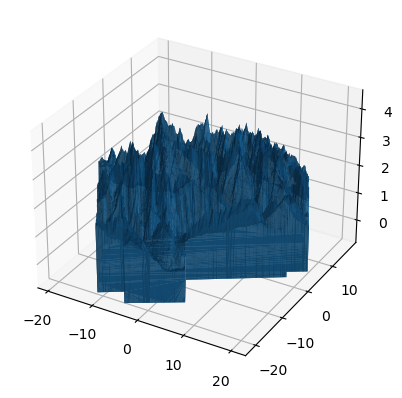

In [1]:
filename = "./source/MontBlanc.glb"
import trimesh
mesh = trimesh.load(filename, force='mesh')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(mesh.vertices[:,0], 
                mesh.vertices[:,2], 
                triangles=mesh.faces, 
                Z=mesh.vertices[:,1],
               ) 
plt.show()

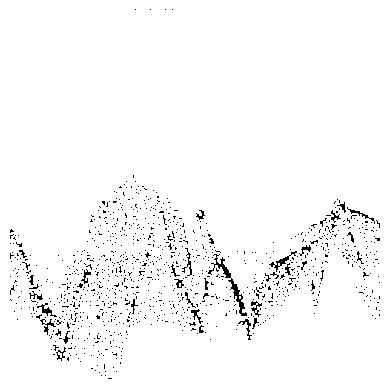

In [2]:
import scipy
import numpy as np
import trimesh
import matplotlib.pyplot as plt

def generate_ring_vertices(in_mesh,center, r_outer, r_inner):
    vertex_mask = np.logical_and(
        (in_mesh.vertices[:,0]-center[0])**2 +\
                  (in_mesh.vertices[:,2]-center[1])**2\
                   < r_outer**2,
               (in_mesh.vertices[:,0]-center[0])**2 +\
                  (in_mesh.vertices[:,2]-center[1])**2\
                   > r_inner**2 
                        )
    return in_mesh.vertices[vertex_mask]

def generate_flattened_image_data(vertices, 
                                  center, 
                                  BINS=500,
                                  STEP=1,
sigma=0,
                                 ):
    X=vertices[::STEP,0]-center[0]
    Y=vertices[::STEP,2]-center[1]
    Z=vertices[::STEP,1]
    X_flatten = np.arctan2(X,Y)
    H, _, _, _ =scipy.stats.binned_statistic_2d(X_flatten, 
                                Z, 
                                np.ones(np.shape(X_flatten)),
                                bins=BINS,
                                statistic='count'
                                       )
    H = scipy.ndimage.zoom(H, 5, order=1)
    H = scipy.ndimage.gaussian_filter(H, sigma=sigma)
    H = np.ma.masked_where(H==0, H)
    
    return H

filename = "./source/MontBlanc.glb"
mesh = trimesh.load(filename, force='mesh')

gj_center = (-0.383453,4.553252)
vertices  =     generate_ring_vertices(mesh,
                              gj_center,
                              r_outer = 4.5,
                              r_inner = 0
                                      )


bins = 500
step = 12
sigma = 1
points = generate_flattened_image_data(vertices, 
                                        gj_center,
                                        BINS=bins,
                                        STEP=step,                                         
                                  sigma=(sigma,sigma)
                                       )
to_plot = points.T
plt.imshow(to_plot, cmap='magma', vmax=100)
plt.axis('off')
plt.savefig(f'bins{bins}_step{step}_sigma{sigma}.jpg', bbox_inches='tight')
plt.show()


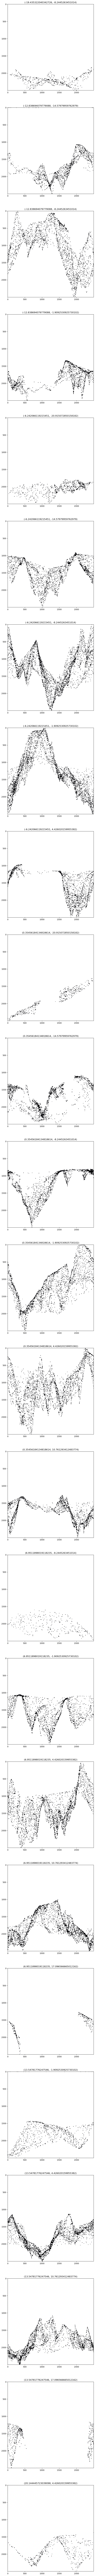

In [7]:
from itertools import product
x_min = mesh.bounds[0][0]
x_max = mesh.bounds[1][0]
y_min = mesh.bounds[0][2]
y_max = mesh.bounds[1][2]
x_points = np.linspace(x_min, x_max,7)
y_points = np.linspace(y_min, y_max,7)


ring_centers = list(product(x_points, y_points))

valid_plots = {}
for c in ring_centers:
    vertices  =     generate_ring_vertices(mesh,
                              c,
                              r_outer = 4,
                              r_inner = 0
                                      )


    bins = 500
    step = 12
    sigma = 1
    if np.count_nonzero(vertices)<10000:
        continue
    points = generate_flattened_image_data(vertices, 
                                            c,
                                            BINS=bins,
                                            STEP=step,                                         
                                      sigma=(sigma,sigma)
                                           )
    to_plot = points.T
    valid_plots[c] = to_plot
    
fig = plt.figure(figsize=(2*6.4,2*4.8*len(valid_plots)))
for i_plot, (c, to_plot) in enumerate(valid_plots.items()):
    ax = plt.subplot(len(valid_plots),1,i_plot+1)
    ax.imshow(to_plot, cmap='magma', vmax=100)
    ax.set_title(c)
